## Train AST - Rémi Ançay - 2025

This notebook allows to train an AST (Audio Spectrogram Transformer) model on a dataset of audio files.

Configure your dataset path, your parameters, and the model path below, then run the cells to train the model.
You can also modify the "Set up train" part with the parameters you want to use for training.

In [1]:
# Imports
from datasets import Dataset, DatasetDict, Audio
from transformers import ASTFeatureExtractor, ASTForAudioClassification, TrainingArguments, Trainer, ASTConfig
from sklearn.model_selection import train_test_split
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

c:\Users\remia\anaconda3\envs\tbLoup\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configuration
TRAIN_FROM_SCRATCH = False  # Set to True if you want to train from scratch

output_dir = "./OutputClassifier/ASTBarkopediaIndividual"
logs_dir = "./LogsClassifier/ASTBarkopediaIndividual"

path_to_dataset = "Datasets/BarkopediaIndividualDataset/"

In [ ]:
# Load the audio dataset in a correct format
def load_audio_dataset(root_dir):
    data = {"file": [], "label": []}
    split_dir = os.path.join(root_dir, "train")
    for label_name in os.listdir(split_dir):
        label_dir = os.path.join(split_dir, label_name)
        if not os.path.isdir(label_dir):
            continue
        for filename in os.listdir(label_dir):
            if filename.endswith(".wav"):
                data["file"].append(os.path.join(label_dir, filename))
                data["label"].append(label_name)

    raw_dataset = Dataset.from_dict(data)

    raw_dataset = raw_dataset.cast_column("file", Audio(sampling_rate=16000))
    raw_dataset = raw_dataset.class_encode_column("label")

    return DatasetDict({
        "train": raw_dataset
    })

In [4]:
dataset = load_audio_dataset(path_to_dataset)

Casting to class labels: 100%|██████████| 441/441 [00:00<00:00, 27614.29 examples/s]


In [5]:
dataset["train"][0]  # Check the first example

{'file': {'path': 'Datasets/BarkopediaIndividualDataset/train\\dog_1\\combined_1.wav',
  'array': array([ 3.05175781e-05,  0.00000000e+00,  0.00000000e+00, ...,
         -2.44140625e-04,  6.40869141e-04,  1.52587891e-04]),
  'sampling_rate': 16000},
 'label': 0}

In [6]:
# Split the dataset into training and validation sets
train_test = dataset["train"]
train_indices, val_indices = train_test_split(list(range(len(train_test))), test_size=0.2, stratify=train_test["label"], random_state=42)
dataset["train"] = train_test.select(train_indices)
dataset["validation"] = train_test.select(val_indices)

In [7]:
print(f"Training samples: {len(dataset['train'])}, Validation samples: {len(dataset['validation'])}")

Training samples: 352, Validation samples: 89


In [ ]:
# Feature extraction
feature_extractor = ASTFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

def preprocess(example):
    audio_data = example["file"]["array"]
    sampling_rate = example["file"]["sampling_rate"]

    extracted_features = feature_extractor(
        audio_data,
        sampling_rate=sampling_rate,
        return_tensors="pt"
    )

    input_values = extracted_features["input_values"].squeeze(0)

    return {
        "input_values": input_values,
        "labels": int(example["label"])

    }

dataset = dataset.map(preprocess, remove_columns=["file"])

Map: 100%|██████████| 89/89 [00:00<00:00, 117.93 examples/s]


In [9]:
# Load the pre-trained model or initialize a new one
id2label = {i: label for i, label in enumerate(dataset["train"].features["label"].names)}
label2id = {v: k for k, v in id2label.items()}


if TRAIN_FROM_SCRATCH:
    config = ASTConfig(
        num_labels=len(id2label),
        id2label=id2label,
        label2id=label2id,
    )
    model = ASTForAudioClassification(config)
else :
    model = ASTForAudioClassification.from_pretrained(
        "MIT/ast-finetuned-audioset-10-10-0.4593",
        num_labels=len(id2label),
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True
    )

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Set up train
args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=11,
    logging_dir=logs_dir,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
)

def compute_metrics(eval_pred):
    pred_logits, labels = eval_pred
    predictions = np.argmax(pred_logits, axis=-1)
    acc = (predictions == labels).mean()
    return {"accuracy": acc}

def custom_collate_fn(batch):
    input_values = [torch.tensor(item["input_values"]) for item in batch]
    labels = [item["labels"] for item in batch]

    return {
        "input_values": torch.stack(input_values),
        "labels": torch.tensor(labels, dtype=torch.long)
    }

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=custom_collate_fn
)

C:\Users\remia\AppData\Local\Temp\ipykernel_15060\4013307857.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Train
trainer.train()

# If the model was already trained and you want to continue training
#trainer.args.num_train_epochs = 15 # Number of epochs to reach
#trainer.train(resume_from_checkpoint=True)

c:\Users\remia\anaconda3\envs\tbLoup\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.700023,0.808989
2,No log,0.403493,0.887640
3,No log,0.262367,0.921348
4,No log,0.301810,0.898876
5,No log,0.293644,0.898876
6,No log,0.290775,0.898876
7,No log,0.289680,0.910112
8,No log,0.290631,0.910112
9,No log,0.291165,0.910112
10,No log,0.291728,0.910112


c:\Users\remia\anaconda3\envs\tbLoup\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\remia\anaconda3\envs\tbLoup\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\remia\anaconda3\envs\tbLoup\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\remia\anaconda3\envs\tbLoup\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\remia\anaconda3\envs\tbLoup\Lib\site-packag

TrainOutput(global_step=484, training_loss=0.08360768152662545, metrics={'train_runtime': 8740.932, 'train_samples_per_second': 0.443, 'train_steps_per_second': 0.055, 'total_flos': 2.6247388930768896e+17, 'train_loss': 0.08360768152662545, 'epoch': 11.0})

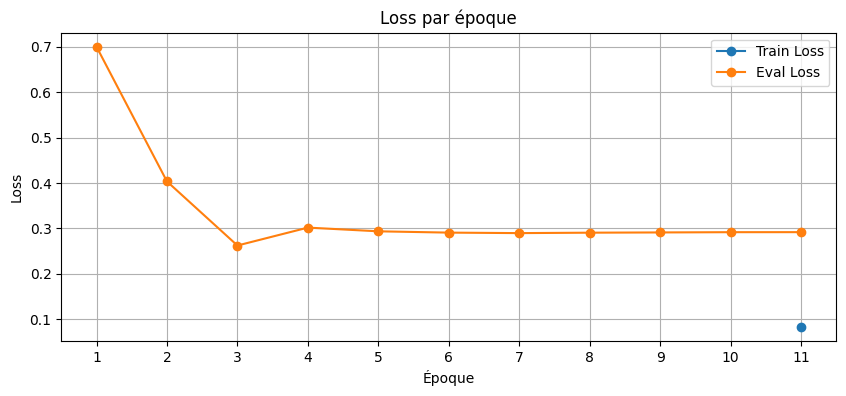

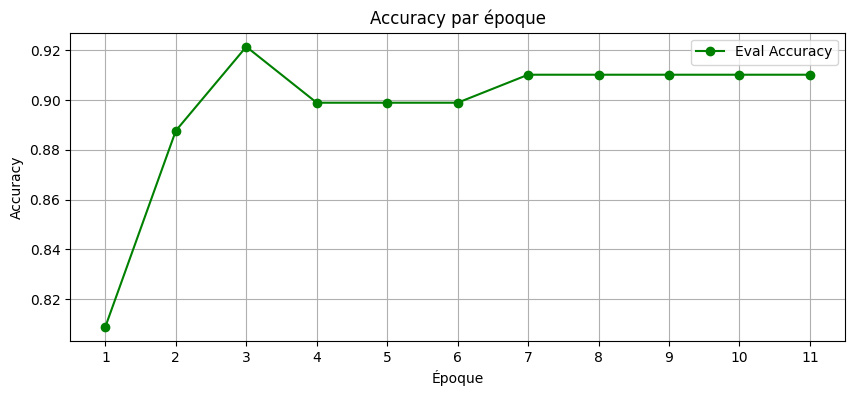

In [ ]:
# Plot results
log_history = trainer.state.log_history
df = pd.DataFrame(log_history)

df_train = df[df["train_loss"].notna()]
df_eval = df[df["eval_loss"].notna()]

epochs = sorted(set(int(e) for e in df["epoch"].dropna().unique()))

# Loss plot
plt.figure(figsize=(10, 4))
plt.plot(df_train["epoch"], df_train["train_loss"], label="Train Loss", marker="o")
plt.plot(df_eval["epoch"], df_eval["eval_loss"], label="Eval Loss", marker="o")
plt.xticks(epochs) 
plt.title("Loss par époque")
plt.xlabel("Époque")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy plot
plt.figure(figsize=(10, 4))
plt.plot(df_eval["epoch"], df_eval["eval_accuracy"], label="Eval Accuracy", color="green", marker="o")
plt.xticks(epochs)
plt.title("Accuracy par époque")
plt.xlabel("Époque")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
#save the model
model.save_pretrained(output_dir)
feature_extractor.save_pretrained(output_dir)

['./OutputClassifier/ASTBarkopediaIndividual\\preprocessor_config.json']